# ----------------------------------------------------------------------
# Mutex Runs
# ----------------------------------------------------------------------


Mutex is a software package for finding mutual exclusivity and co-occurrence in cancer genes.

__To disregard the FDR and filtering method__, set:
1. leastPatientThreshold to 100
2. test_gene_threshold to 0
3. mpairPercntile to 100
4. cpairPercentile to 100

# Set parameters

In [11]:
mutationmatrix = 'data/BRCA_wustl-som.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# only load patients listed in this file. Set to None to use all the patients.

geneFile = None
# Only load genes listed in this file. Set to None to use all the patients


output_prefix =  "output/BRCA_wustl-som-weSMEcomp-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"

# If you want to test all pairs without first using the least mutated patients, run the following cell.

In [14]:
minFreq = 0
leastPatientThreshold = 100
test_gene_threshold = 0
closer_than_distance = 100000000
only_filter_copy_distance = True
cFDRthreshold = 0.05
mFDRthreshold = 0.05
pairs_have_dependencies = True
remove_missing_genes = False

# Otherwise, set the parameters in the following cell and run it.

In [15]:
minFreq = 0
# Only load genes mutated at least this many times.


leastPatientThreshold = 100
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 1.5
# Test genes that are mutated in at least this percentage of the least mutated patients.



closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. Default is False.

cFDRthreshold = 0.05
# FDR threshold for c-pvalues.

mFDRthreshold = 0.05
# FDR threshold for mutually exclusive pairs.

pairs_have_dependencies = True

remove_missing_genes = False

# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

17637 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


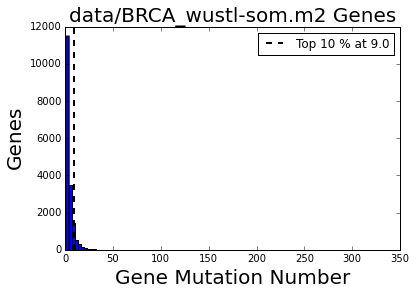

Zoomed into bottom 95 percent region


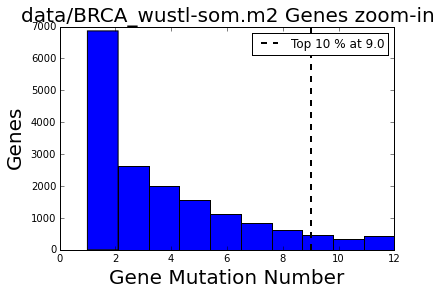


PATIENT MUTATION DISTRIBUTION


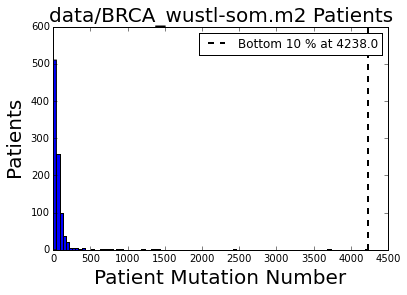

Zoomed into bottom 95 percent region


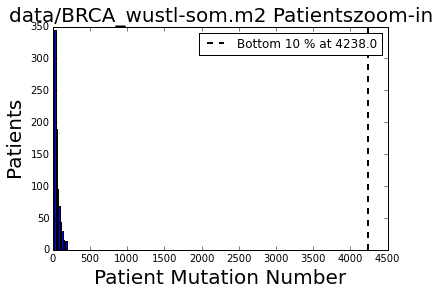

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


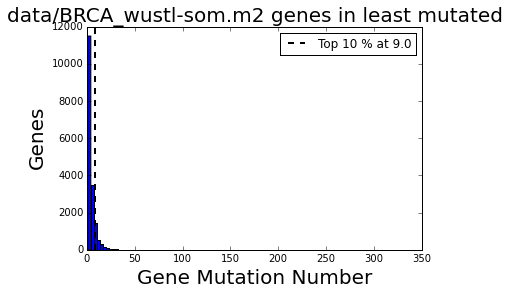


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


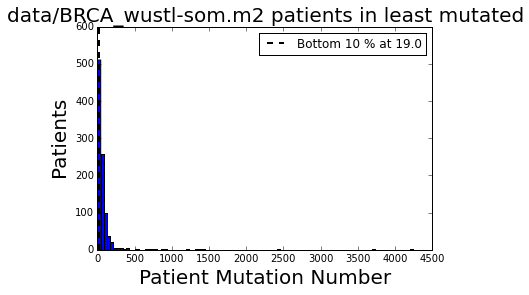

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  100  % of patients
Least mutated patients: 17637 genes x 963 patients
The test gene threshold is  1.5 % of the least mutated patients
Test genes are mutated at least  14  in th least mutated patients
Number of test genes:  669
Number of pairs to test:  223446
Number of pairs is  223446  retrieved in time :  93.9471929073


0

In [16]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
import multi_testing as mt
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])

t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, remove_missing_genes=remove_missing_genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [17]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  123.57483983
Testing among least mutated patients...
Finished in  973.947735071
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-weSMEcomp-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Run weSME

In [18]:
num_samples = 1000
pthresh = 0.05
num_permute = 100

bin_threshold = test_minFreq

cancer_name = mutationmatrix.split("/")[-1][:-3]

weSME_folder = '/Users/jlu96/conte/wsampling/'
weSME_data_folder = '/Users/jlu96/conte/wsampling/data/' + cancer_name + '/'
weSME_file = weSME_data_folder + cancer_name + "-list.txt"
weSME_freq_file = weSME_data_folder + cancer_name + "-freqs.txt"
weSME_sampling_folder = weSME_data_folder + 'sampling/'
weSME_permute_folder = weSME_data_folder + 'permute/'
weSME_permute_prefix = weSME_permute_folder + "permute"
me_output = weSME_data_folder + "ME_" + str(pthresh) + ".txt"
co_output = weSME_data_folder + "CO_" + str(pthresh) + ".txt"
permute_me_output_prefix = weSME_permute_folder + "permute_output_ME_" + str(pthresh)
permute_co_output_prefix = weSME_permute_folder + "permute_output_CO_" + str(pthresh)
fdr_me_output = weSME_data_folder + "ME_FDR.txt"
fdr_co_output = weSME_data_folder + "CO_FDR.txt"
pv_fdr_me_output = weSME_data_folder + "pv_ME_FDR.txt"
pv_fdr_co_output = weSME_data_folder + "pv_CO_FDR.txt"


comp_sample_weights = weSME_folder + 'comp_sample_weights.py'
comp_me_for_all_pairs = weSME_folder + 'comp_me_for_all_pairs.py'
comp_co_for_all_pairs = weSME_folder + 'comp_co_for_all_pairs.py'
comp_fdr = weSME_folder + 'comp_fdr.py'
run_permute_data = weSME_folder + 'run_permute_data.py'
run_weighted_sampling = weSME_folder + 'run_weighted_sampling.py'

In [65]:
# convert the mutationmatirx to weSME format

!mkdir $weSME_data_folder
!python preprocessing/matrixToMut_list.py -i $mutationmatrix -o $weSME_file


mkdir: /Users/jlu96/conte/wsampling/data/BRCA_wustl-som/: File exists
WeSME mut_list written to  /Users/jlu96/conte/wsampling/data/BRCA_wustl-som/BRCA_wustl-som-list.txt


In [66]:
# sample

!python $comp_sample_weights $cancer_name $cancer_name -i $weSME_file -o $weSME_freq_file
!mkdir $weSME_sampling_folder

print "Making samples"
!time python $run_weighted_sampling $cancer_name $cancer_name $num_samples -m $weSME_file -f $weSME_freq_file -o $weSME_sampling_folder
!echo "Sampling written to " $weSME_sampling_folder

INFO:root:BRCA_wustl-som
mkdir: /Users/jlu96/conte/wsampling/data/BRCA_wustl-som/sampling/: File exists
Making samples
INFO:root:BRCA_wustl-som
INFO:root:for all observed k's

real	0m29.327s
user	0m26.609s
sys	0m0.629s
Sampling written to  /Users/jlu96/conte/wsampling/data/BRCA_wustl-som/sampling/


In [7]:
# Get mutex + co-occurrence
!time python $comp_me_for_all_pairs $cancer_name $cancer_name $pthresh -m $weSME_file -s $weSME_sampling_folder -o $me_output
!echo "Mutex written to " $me_output
!time python $comp_co_for_all_pairs $cancer_name $cancer_name $pthresh -m $weSME_file -s $weSME_sampling_folder -o $co_output
!echo "Cooccur written to " $co_output

os.system('Pairs completed"')

DEBUG:root:comp ME for BRCA_wustl-som, BRCA_wustl-som
INFO:root:0 
^CTraceback (most recent call last):
  File "/Users/jlu96/conte/wsampling/comp_me_for_all_pairs.py", line 83, in <module>
    (covers, ws_k_cover_dic, max_pair_num=10**5, ws_ex_cover_sizes_dic=ws_ex_cover_sizes_dic)
  File "/Users/jlu96/conte/wsampling/mut_ex/ws_mut_ex.py", line 134, in compute_me_co_pv_ws
    compute_ws_cover_sizes(cover_sizes, ws_k_cover_dic, init_pair_num, ws_ex_cover_sizes_dic)
  File "/Users/jlu96/conte/wsampling/mut_ex/ws_mut_ex.py", line 102, in compute_ws_cover_sizes
    [len(compute_ex_cover(random_covers[i])) for i in range(len(random_covers))] # NULL ex_cover_sizes
  File "/Users/jlu96/conte/wsampling/mut_ex/ws_mut_ex.py", line 22, in compute_ex_cover
    cross_cov = cross_cov.union(union_cov.intersection(cov))
KeyboardInterrupt


real	0m5.639s
user	0m4.408s
sys	0m0.618s
Mutex written to  /Users/jlu96/conte/wsampling/data/BRCA_wustl-som/ME_0.05.txt
DEBUG:root:comp CO for BRCA_wustl-som, BRCA_

512

In [10]:
# compute FDR
# CHECK TO MAKE SURE ME AND CO ARE WRITTEN TO THE RIGHT FILES ANDL OADED RIGHT BY FDR
import time 
!mkdir $weSME_permute_folder

t = time.time()
for i in range(num_permute):
    permute_file = weSME_permute_prefix  + "_" + str(i) + ".txt"
    me_output_file = permute_me_output_prefix + str(i) + ".txt"
    co_output_file = permute_co_output_prefix + str(i) + ".txt"
    
    print "FILE ", i
    print "Permuting"
    !time python $run_permute_data $cancer_name $cancer_name $i $num_permute -i $weSME_file -p $weSME_permute_prefix
    print "ME"
    !time python $comp_me_for_all_pairs $cancer_name $cancer_name $pthresh -m $permute_file -s $weSME_sampling_folder -o $me_output_file
    print "CO"
    !time python $comp_co_for_all_pairs $cancer_name $cancer_name $pthresh -m $permute_file -s $weSME_sampling_folder -o $co_output_file
print "Time used for running over permutes: ", time.time() - t    

os.system('Permutes completed"')

print "FDR ME"
!time python $comp_fdr $cancer_name $cancer_name me $num_permute $bin_threshold -m $weSME_file -p $me_output -n $permute_me_output_prefix -f $fdr_me_output -pf $pv_fdr_me_output

print "FDR CO"
!time python $comp_fdr $cancer_name $cancer_name co $num_permute $bin_threshold -m $weSME_file -p $co_output -n $permute_co_output_prefix -f $fdr_co_output -pf $pv_fdr_co_output
    


mkdir: /Users/jlu96/conte/wsampling/data/BRCA_wustl-som/permute/: File exists
FILE  0
Permuting
INFO:root:0-th permutation.. (permute 100 times)
INFO:root:
****** reading mutation data files (BRCA_wustl-som)...

DEBUG:root:10000 swaps..

DEBUG:root:20000 swaps..

DEBUG:root:30000 swaps..

DEBUG:root:40000 swaps..

DEBUG:root:50000 swaps..

DEBUG:root:60000 swaps..

DEBUG:root:70000 swaps..

DEBUG:root:80000 swaps..

DEBUG:root:90000 swaps..

DEBUG:root:100000 swaps..

DEBUG:root:110000 swaps..

DEBUG:root:120000 swaps..

DEBUG:root:130000 swaps..

DEBUG:root:140000 swaps..

DEBUG:root:150000 swaps..

DEBUG:root:160000 swaps..

DEBUG:root:170000 swaps..

DEBUG:root:180000 swaps..

DEBUG:root:190000 swaps..

DEBUG:root:200000 swaps..

DEBUG:root:210000 swaps..

DEBUG:root:220000 swaps..

DEBUG:root:230000 swaps..

DEBUG:root:240000 swaps..

DEBUG:root:250000 swaps..

DEBUG:root:260000 swaps..

DEBUG:root:270000 swaps..

DEBUG:root:280000 swaps..

DEBUG:root:290000 swaps..

DEBUG:root:300

UnboundLocalError: local variable 'child' referenced before assignment

In [11]:
!wc -l $weSME_file

   17690 /Users/jlu96/conte/wsampling/data/BRCA_wustl-som/BRCA_wustl-som-list.txt


In [19]:
# Use Edgereader to integrate cpairs and mpairs
me_integrated = pairfile[:-4] + "_weSME_integrated_me.txt"
co_integrated = pairfile[:-4] + "_weSME_integrated_co.txt"
!time python postprocessing/result_combiner.py -i $pairfile $me_output -o $me_integrated
!time python postprocessing/result_combiner.py -i $pairfile $co_output -o $co_integrated


Number of overlapps among files 6932
Combined data frames file written to  output/BRCA_wustl-som-weSMEcomp-pairs-min_cohort_weSME_integrated_me.txt

real	0m4.899s
user	0m3.138s
sys	0m0.662s
Number of overlapps among files 6413
Combined data frames file written to  output/BRCA_wustl-som-weSMEcomp-pairs-min_cohort_weSME_integrated_co.txt

real	0m22.339s
user	0m17.485s
sys	0m3.005s


# plot the p-values of mutex in each

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


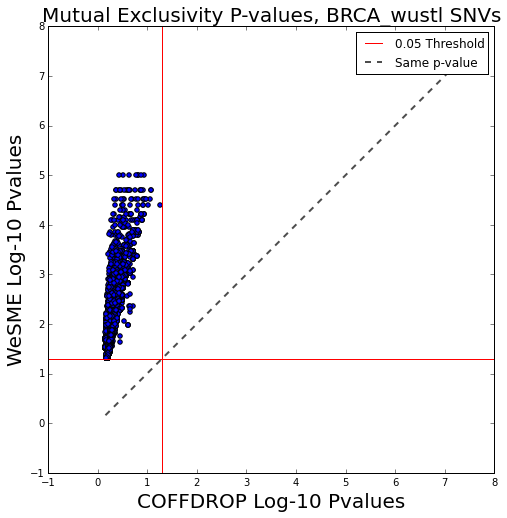

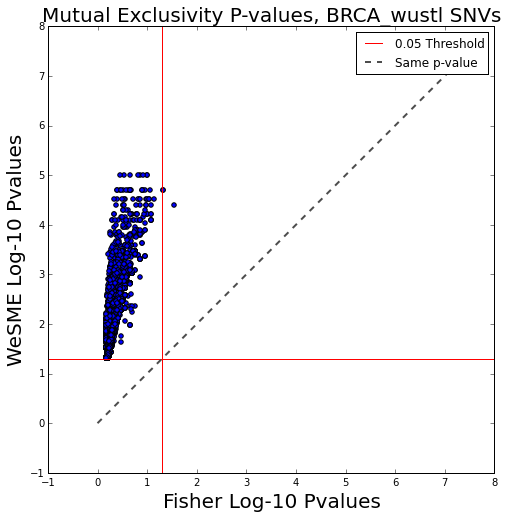

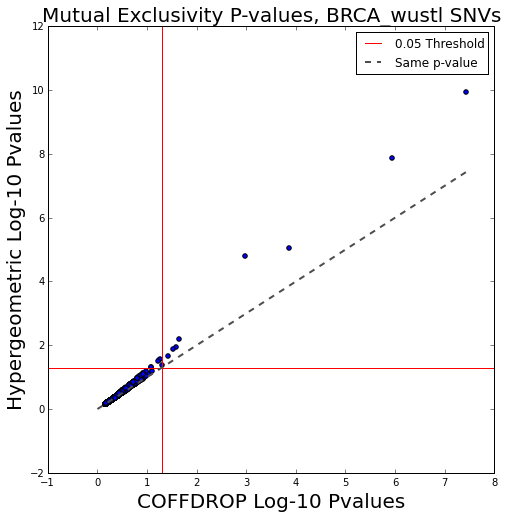

In [20]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv(me_integrated, sep='\t')
df_me = df[df['Type'] == "MutuallyExclusive"]

f, ax = plt.subplots(figsize=(8, 8))
plt.scatter(-np.log10(df_me['AllMBinomProb']), -np.log10(df_me['pv (ws)']))
plt.xlabel("COFFDROP Log-10 Pvalues", fontsize=20)
plt.ylabel("WeSME Log-10 Pvalues", fontsize=20)
plt.axvline(x=-np.log10(0.05), color='red', label='0.05 Threshold')
plt.axhline(y=-np.log10(0.05), color='red')

line_xs = np.linspace((-np.log10(df_me['AllMBinomProb'])).min(), (-np.log10(df_me['AllMBinomProb'])).max(), 100)

ax.plot(line_xs, line_xs, ls="--", c=".3", linewidth=2,label="Same p-value")
plt.legend()
plt.title("Mutual Exclusivity P-values, BRCA_wustl SNVs", fontsize=20)




f, ax = plt.subplots(figsize=(8, 8))
plt.scatter(-np.log10(df_me['MutexProb']), -np.log10(df_me['pv (ws)']))
plt.xlabel("Fisher Log-10 Pvalues", fontsize=20)
plt.ylabel("WeSME Log-10 Pvalues", fontsize=20)
plt.axvline(x=-np.log10(0.05), color='red', label='0.05 Threshold')
plt.axhline(y=-np.log10(0.05), color='red')
line_xs = np.linspace(0, (-np.log10(df_me['AllMBinomProb'])).max(), 100)
ax.plot(line_xs, line_xs, ls="--", c=".3", linewidth=2,label="Same p-value")
plt.legend()
plt.title("Mutual Exclusivity P-values, BRCA_wustl SNVs", fontsize=20)



f, ax = plt.subplots(figsize=(8, 8))
plt.scatter(-np.log10(df_me['AllMBinomProb']), -np.log10(df_me['MutexProb']))
plt.ylabel("Hypergeometric Log-10 Pvalues", fontsize=20)
plt.xlabel("COFFDROP Log-10 Pvalues", fontsize=20)
plt.axvline(x=-np.log10(0.05), color='red', label='0.05 Threshold')
plt.axhline(y=-np.log10(0.05), color='red')
line_xs = np.linspace(0, (-np.log10(df_me['AllMBinomProb'])).max(), 100)
ax.plot(line_xs, line_xs, ls="--", c=".3", linewidth=2,label="Same p-value")
plt.legend()
plt.title("Mutual Exclusivity P-values, BRCA_wustl SNVs", fontsize=20)



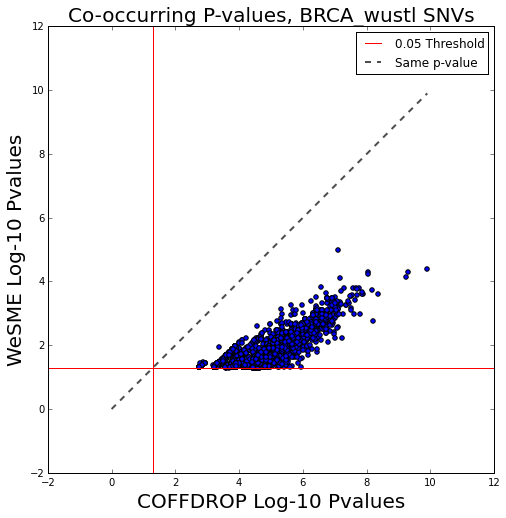

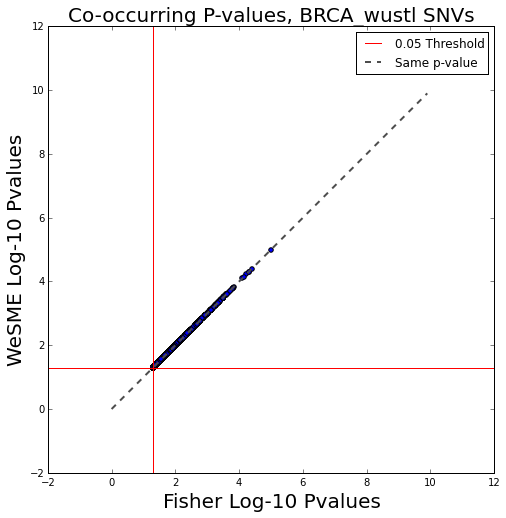

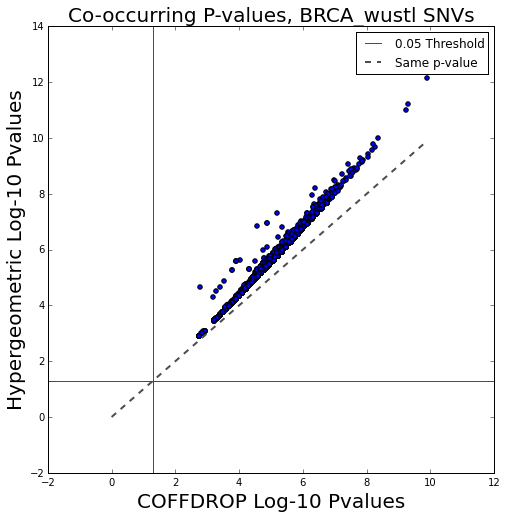

In [21]:
df = pd.read_csv(co_integrated, sep='\t')
df_co = df

f, ax = plt.subplots(figsize=(8, 8))
plt.scatter(-np.log10(df_co['AllCBinomProb']), -np.log10(df_co['pv (ws)']))
plt.xlabel("COFFDROP Log-10 Pvalues", fontsize=20)
plt.ylabel("WeSME Log-10 Pvalues", fontsize=20)
plt.axvline(x=-np.log10(0.05), color='red', label='0.05 Threshold')
plt.axhline(y=-np.log10(0.05), color='red')
line_xs = np.linspace(0, (-np.log10(df_co['AllCBinomProb'])).max(), 100)
ax.plot(line_xs, line_xs, ls="--", c=".3", linewidth=2,label="Same p-value")
plt.legend()
plt.title("Co-occurring P-values, BRCA_wustl SNVs", fontsize=20)


f, ax = plt.subplots(figsize=(8, 8))
plt.scatter(-np.log10(df_co['pv (ws)']), -np.log10(df_co['pv (ws)']))
plt.xlabel("Fisher Log-10 Pvalues", fontsize=20)
plt.ylabel("WeSME Log-10 Pvalues", fontsize=20)
plt.axvline(x=-np.log10(0.05), color='red', label='0.05 Threshold')
plt.axhline(y=-np.log10(0.05), color='red')
line_xs = np.linspace(0, (-np.log10(df_co['AllCBinomProb'])).max(), 100)
ax.plot(line_xs, line_xs, ls="--", c=".3", linewidth=2,label="Same p-value")
plt.legend()
plt.title("Co-occurring P-values, BRCA_wustl SNVs", fontsize=20)



f, ax = plt.subplots(figsize=(8, 8))
plt.scatter(-np.log10(df_co['AllCBinomProb']), -np.log10(df_co['Probability']))
plt.ylabel("Hypergeometric Log-10 Pvalues", fontsize=20)
plt.xlabel("COFFDROP Log-10 Pvalues", fontsize=20)
plt.axvline(x=-np.log10(0.05), color='red', label='0.05 Threshold')
plt.axhline(y=-np.log10(0.05), color='red')
line_xs = np.linspace(0, (-np.log10(df_co['AllCBinomProb'])).max(), 100)
ax.plot(line_xs, line_xs, ls="--", c=".3", linewidth=2,label="Same p-value")
plt.legend()
plt.title("Co-occurring P-values, BRCA_wustl SNVs", fontsize=20)

In [10]:
!head $co_integrated

In [25]:
inputs = [pairfile, me_output]
gene_column_names = frozenset(['Gene0', 'Gene1'])


dfs = []
for input_file in inputs:
    dfs.append(pd.read_csv(input_file, sep='\t'))


# make column combining gene names by alphabetic order
for df in dfs:
    gene_columns = [df[gene_column_name] for gene_column_name in gene_column_names]
    zipped = zip(*gene_columns)

    sorted_zipped = [sorted(zip_pair) for zip_pair in zipped]
    combined_zipped = ["-".join(s) for s in sorted_zipped]
    df['Genes'] = combined_zipped

In [33]:
print dfs[0].shape, dfs[1].shape

(223446, 23) (14519, 5)


In [30]:
genes_set = set(dfs[0]['Genes'].values)
for df in dfs:
    genes_set = genes_set.intersection(set(df['Genes'].values))

In [31]:
genes_set

{'TNRC6C-TP53',
 'BCR-FAT3',
 'ASTN1-MAP3K1',
 'HUWE1-TBP',
 'CROCCP2-WNK1',
 'CROCCP2-WNK3',
 'FBN1-GATA3',
 'MUC4-ZFHX4',
 'CIT-GOLGA6L2',
 'CROCCP2-PKD1',
 'GATA3-POTEF',
 'CSMD1-HTT',
 'CCDC168-MAP2K4',
 'FAM75D5-PTEN',
 'TBP-TPR',
 'CBFB-KIAA1210',
 'MXRA5-RNA5-8SP6',
 'F5-TBP',
 'ADAMTS20-PIK3CA',
 'NLRC5-TBX3',
 'SDHAP1-SPTA1',
 'CDH1-GCN1L1',
 'KIAA0430-TP53',
 'RUNX1-TRRAP',
 'GPR98-HLA-DRB1',
 'FAM157B-PKHD1',
 'DNAH5-OTOF',
 'ABCA4-MAP3K1',
 'MACF1-NF1',
 'MAP3K1-SSPO',
 'MUC19-TTN',
 'GATA3-SETX',
 'DNAH10-MAP2K4',
 'FRG1B-MAP2K4',
 'ADAMTSL1-COL6A3',
 'MLL3-PTEN',
 'ODZ1-TTN',
 'CDH1-UNC5D',
 'CTNNA2-GOLGA6L2',
 'DSCAM-MLL3',
 'MUC4-PIKFYVE',
 'FAT1-TP53',
 'OTOF-TTN',
 'CROCCP2-PXDN',
 'EML5-MUC4',
 'HYDIN-LOXHD1',
 'MAP3K1-XIRP2',
 'HECW2-RUNX1',
 'CDH1-IGSF1',
 'LOXHD1-LRP2',
 'NBPF10-NEB',
 'RNA5-8SP6-TP53',
 'MAP3K1-RP1L1',
 'FAM157B-LRP1',
 'FAM157B-LRP2',
 'GOLGA6L2-KAT6B',
 'GCN1L1-TBP',
 'DNAH17-SPEG',
 'FRG1B-KIAA0430',
 'HERC1-TP53',
 'FAM157B-FCGBP',
 'APOBR-NA

In [43]:
new_dfs = []
for df in dfs:

    new_df = df[df['Genes'].isin(genes_set)]

    new_df = new_df.sort_values(by='Genes')
    new_df.reset_index(inplace=True)
    new_dfs.append(new_df)

In [45]:
new_dfs[0].shape, new_dfs[1].shape
new_dfs[0].head()

,index,Gene0,Gene1,Type,1MBinomProb0,1CBinomProb0,MutationFrequency0,MutationFrequency1,Probability,Overlap,...,AllCBinomProb,AllMBinomProb,1Size0,1Freqs0,1Overlap0,1CBinomProb0.1,1MBinomProb0.1,1CAllSig,1MAllSig,Genes
0,186051,ABCA10,CROCCP2,MutuallyExclusive,0.399987,1.000000,14,63,1.000000,0,...,1.000000,0.399987,963,"[14, 63]",0,1.000000,0.399987,True,True,ABCA10-CROCCP2
1,115323,ABCA10,GATA3,MutuallyExclusive,0.240323,1.000000,14,98,1.000000,0,...,1.000000,0.240323,963,"[14, 98]",0,1.000000,0.240323,True,True,ABCA10-GATA3
2,162627,ABCA10,MAP3K1,Cooccurring,0.718565,0.649116,14,72,0.665673,1,...,0.649116,0.718565,963,"[14, 72]",1,0.649116,0.718565,True,True,ABCA10-MAP3K1
3,125322,ABCA10,TBP,MutuallyExclusive,0.592439,1.000000,14,36,1.000000,0,...,1.000000,0.592439,963,"[14, 36]",0,1.000000,0.592439,True,True,ABCA10-TBP
4,121334,ABCA12,ANKRD30BL,MutuallyExclusive,0.654575,1.000000,17,24,1.000000,0,...,1.000000,0.654575,963,"[17, 24]",0,1.000000,0.654575,True,True,ABCA12-ANKRD30BL


In [46]:
out_df = pd.concat(new_dfs, axis = 1)
out_df.shape

(6932, 30)

In [47]:
out_df.head()


,index,Gene0,Gene1,Type,1MBinomProb0,1CBinomProb0,MutationFrequency0,MutationFrequency1,Probability,Overlap,...,1MBinomProb0.1,1CAllSig,1MAllSig,Genes,index,Gene0,Gene1,jaccard index,pv (ws),Genes
0,186051,ABCA10,CROCCP2,MutuallyExclusive,0.399987,1.000000,14,63,1.000000,0,...,0.399987,True,True,ABCA10-CROCCP2,8340,ABCA10,CROCCP2,0.000000,0.00763,ABCA10-CROCCP2
1,115323,ABCA10,GATA3,MutuallyExclusive,0.240323,1.000000,14,98,1.000000,0,...,0.240323,True,True,ABCA10-GATA3,13326,ABCA10,GATA3,0.000000,0.00152,ABCA10-GATA3
2,162627,ABCA10,MAP3K1,Cooccurring,0.718565,0.649116,14,72,0.665673,1,...,0.718565,True,True,ABCA10-MAP3K1,6495,ABCA10,MAP3K1,0.011765,0.04428,ABCA10-MAP3K1
3,125322,ABCA10,TBP,MutuallyExclusive,0.592439,1.000000,14,36,1.000000,0,...,0.592439,True,True,ABCA10-TBP,12738,ABCA10,TBP,0.000000,0.03970,ABCA10-TBP
4,121334,ABCA12,ANKRD30BL,MutuallyExclusive,0.654575,1.000000,17,24,1.000000,0,...,0.654575,True,True,ABCA12-ANKRD30BL,906,ABCA12,ANKRD30BL,0.000000,0.04610,ABCA12-ANKRD30BL


In [42]:
out_df.index

RangeIndex(start=0, stop=13630, step=1)

In [49]:
out_df.drop('index', axis=1)

,Gene0,Gene1,Type,1MBinomProb0,1CBinomProb0,MutationFrequency0,MutationFrequency1,Probability,Overlap,MutexProb,...,1CBinomProb0.1,1MBinomProb0.1,1CAllSig,1MAllSig,Genes,Gene0,Gene1,jaccard index,pv (ws),Genes
0,ABCA10,CROCCP2,MutuallyExclusive,0.399987,1.000000,14,63,1.000000,0,0.385235,...,1.000000,0.399987,True,True,ABCA10-CROCCP2,ABCA10,CROCCP2,0.000000,0.00763,ABCA10-CROCCP2
1,ABCA10,GATA3,MutuallyExclusive,0.240323,1.000000,14,98,1.000000,0,0.220172,...,1.000000,0.240323,True,True,ABCA10-GATA3,ABCA10,GATA3,0.000000,0.00152,ABCA10-GATA3
2,ABCA10,MAP3K1,Cooccurring,0.718565,0.649116,14,72,0.665673,1,0.718155,...,0.649116,0.718565,True,True,ABCA10-MAP3K1,ABCA10,MAP3K1,0.011765,0.04428,ABCA10-MAP3K1
3,ABCA10,TBP,MutuallyExclusive,0.592439,1.000000,14,36,1.000000,0,0.584439,...,1.000000,0.592439,True,True,ABCA10-TBP,ABCA10,TBP,0.000000,0.03970,ABCA10-TBP
4,ABCA12,ANKRD30BL,MutuallyExclusive,0.654575,1.000000,17,24,1.000000,0,0.648757,...,1.000000,0.654575,True,True,ABCA12-ANKRD30BL,ABCA12,ANKRD30BL,0.000000,0.04610,ABCA12-ANKRD30BL
5,ABCA12,CBFB,MutuallyExclusive,0.654575,1.000000,17,24,1.000000,0,0.648757,...,1.000000,0.654575,True,True,ABCA12-CBFB,ABCA12,CBFB,0.000000,0.04610,ABCA12-CBFB
6,ABCA12,CROCCP2,Cooccurring,0.694560,0.671360,17,63,0.686577,1,0.693147,...,0.671360,0.694560,True,True,ABCA12-CROCCP2,ABCA12,CROCCP2,0.012346,0.01729,ABCA12-CROCCP2
7,ABCA12,GATA3,MutuallyExclusive,0.483782,0.822993,17,98,0.841294,1,0.470136,...,0.822993,0.483782,True,True,ABCA12-GATA3,ABCA12,GATA3,0.008621,0.00258,ABCA12-GATA3
8,ABCA12,MAP2K4,MutuallyExclusive,0.568322,1.000000,17,32,1.000000,0,0.560228,...,1.000000,0.568322,True,True,ABCA12-MAP2K4,ABCA12,MAP2K4,0.000000,0.02110,ABCA12-MAP2K4
9,PIK3CA,ABCA12,Cooccurring,0.800226,0.326129,316,17,0.308132,7,0.841958,...,0.326129,0.800226,True,True,ABCA12-PIK3CA,PIK3CA,ABCA12,0.021277,0.03941,ABCA12-PIK3CA
